In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
import dask.dataframe as dd
from dask import delayed
from dask_ml.model_selection import train_test_split
import spacy
import spacy_readability
from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# import pyarrow
sns.set_style('darkgrid')
path = '/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/parquet'
%matplotlib inline

In [2]:
# biz = dd.read_json('E:/_Large_datasets/Yelp/business.json', lines=True)#, blocksize=2**28)
rev = dd.read_json('/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/review.json', 
                   lines=True, blocksize=2**22) # lower blocksize (i.e. 2*22) made this work in Linux
# usr = dd.read_json('G:/SharedSpace/_Large_datasets/Yelp/user.json', lines=True, blocksize=2**28)
# rev.to_parquet('/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/parquet/')

# Testing dask compute
# rev.useful.mean().compute()

It has been very painful working with Dask. It is not covered in the course anywhere, even as a more realistic work environment where too much data exists to analyze things in memory. Some basic issues you can not run in Dask include:

- Boolean indexing
- spaCy pipelines (memory allocation)
- Word2Vec conversions (memory allocation)
- Drop duplicates over entire Dask DF **Works?
- Basic computations (very long turn around)

Because of these limitations, some of the work and drudge behing the scenes might not be displayed in the notebook.

In [31]:
rev = rev.drop('review_id', axis=1)
rev = rev.drop_duplicates(subset='text')
rev.head()

,user_id,business_id,stars,useful,funny,cool,text,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


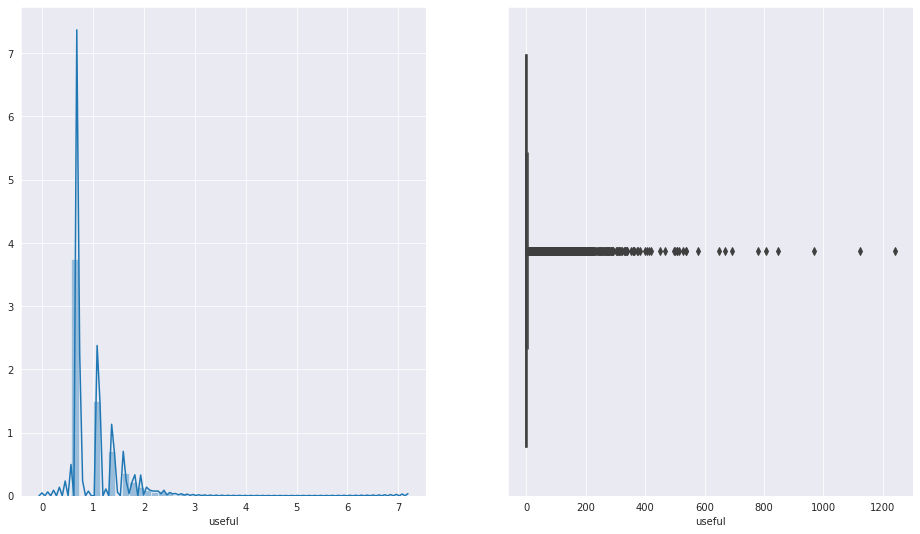

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
sns.distplot(np.log((rev.useful + 2).compute()), ax=ax1)
sns.boxplot(rev.useful.compute(), ax=ax2)

In [51]:
rev[rev.useful == rev.useful.max().compute()].text.compute()

203142    Dinner for 1.\n\n- Preface\nI went to Amy's Ba...
Name: text, dtype: object

In [13]:
nlp = spacy.load('en_core_web_md')
# txt = rev.text.compute()
# use = rev.useful.compute()
# doc = list(nlp.pipe(rev.text.compute()))

### Approaching parsing of vast text
We will try using a spaCy pipeline to handle the parsing as it's very large.

In [58]:
df = pd.read_parquet('/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/parquet/part.0.parquet').set_index('review_id')
df2 = pd.read_parquet('/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/parquet/part.1.parquet').set_index('review_id')

In [60]:
df2.iloc[0]

user_id                                   1dlTeEt4LBKwoKvFbNPL2A
business_id                               5NteKnLm_oMBTALHNiMd6A
stars                                                          1
useful                                                         2
funny                                                          0
cool                                                           0
text           This company replaced the opener motor last ye...
date                                         2018-05-19 00:52:46
Name: Ku8fj3eAI1zMXvRhuzy_AA, dtype: object

In [51]:
txt = list(nlp.pipe(df.text))
txt2 = pd.Series(nlp.pipe(df.text))
txt2

In [52]:
txt2

0       (Total, bill, for, this, horrible, service, ?,...
1       (I, *, adore, *, Travis, at, the, Hard, Rock, ...
2       (I, have, to, say, that, this, office, really,...
3       (Went, in, for, a, lunch, ., Steak, sandwich, ...
4       (Today, was, my, second, out, of, three, sessi...
                              ...                        
5386    (Service, is, fast, and, really, friendly, ., ...
5387    (Amazing, food, ., We, ordered, the, barbecue,...
5388    (We, ordered, from, Yao, Fine, the, day, befor...
5389    (This, place, is, great, ., Total, guilty, ple...
5390    (Great, place, !,  , Tacos, de, carne, asada, ...
Length: 5391, dtype: object

In [ ]:
r = re.compile(r'part.*')
rev_list = list(filter(r.match, os.listdir(path)))

for rev in txt:
    it = [token.lemma_.lower() for token in rev if not token.is_punct and not token.is_stop]
    rev_list.append(it)
    
model = Word2Vec(rev_list)
model.wv.vocab.keys()[:10]